In [158]:
import requests                 # Библиотека работы с HTTP-запросами по API
import json                     # Для обработки полученных результатов запросов
import time                     # Для задержки между запросами
import os                       # Для работы с файлами
import pandas as pd             # Для формирования датафрейма с результатами
import re                       # Для работы с регулярными выражениями
import numpy as np              # Библиотека работы с массивами
import seaborn as sns           # Статистическая визуализация данных
import matplotlib.pyplot as plt # Визуализация данных

In [37]:
def get_vacancies(job_title, page=0, retries=5):
    '''Функция запроса страницы.
       job_title - наименование вакансии
       page - Индекс страницы
       retries - количество попыток повторения запроса
       (по умолчанию начинается с первой страницы)'''

    # Справочник для переменной GET-запроса
    # Значения для указания значений в справочнике 
    # указаны в документации к API hh.ru по ссылке: 
    # https://github.com/hhru/api
    params = {
        'text': job_title,
        'area': 113,
        'page': page,
        'per_page': 100
    }

    for i in range(retries):
        try:
            req = requests.get('https://api.hh.ru/vacancies', params, timeout=20)
            data = req.content.decode()
            req.close()
            return data
        except requests.exceptions.RequestException as e:
            print(f"Ошибка при запросе страницы {page}: {e}")
            print(f"Попытка {i+1}/{retries}...")
            time.sleep(0.25)

    print(f"Не удалось получить данные для страницы {page}")
    return None

# Собираем все вакансии в один JSON-файл
vacancies = []
vacancies_ids = set()
job_titles = [
    "data engineer",
    "data analyst",
    "data scientist",
    "аналитик данных",
    "аналитик",
    "analyst",
    "инженер данных",
    "BI",
    "data",
    "дата",
    "ETL",
]

for job_title in job_titles:
    for page in range(0, 100):
        # Запрашиваем страницу с вакансиями
        response = json.loads(get_vacancies(job_title, page))
        # Получаем список вакансий на странице
        items = response['items']
        for item in items:
            # Проверяем, что вакансия не была уже добавлена в список
            if item['id'] not in vacancies_ids:
                # Проверяем, что в названии вакансии есть искомое слово
                if any(title in item['name'].lower() for title in job_titles):
                    # Добавляем вакансию в список
                    vacancies.append(item)
                    # Добавляем id вакансии во множество уже просмотренных id
                    vacancies_ids.add(item['id'])
        # Проверяем, является ли страница последней
        if response['pages'] - page <= 1:
            break
        # Делаем задержку между запросами
        time.sleep(0.25)

# Сохраняем полученные вакансии в файле
with open('data/vacancies.json', 'w', encoding='utf-8') as f:
    json.dump(vacancies, f, ensure_ascii=False, indent=4)

print('Вакансии по запросу собраны и сохранены в файл vacancies.json')
# Количество вакансий
print(f"Количество собранных вакансий: {len(vacancies)}")

# Количество уникальных значений ключа 'name'
unique_names = set([v['name'] for v in vacancies])
names_count = len(unique_names)

print(f"Количество уникальных названий вакансий: {names_count}")

# Уникальные значения ключа 'name'
names = set([v['name'] for v in vacancies])
print(f"Уникальные названия вакансий: {names}")


Ошибка при запросе страницы 18: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 3: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 9: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 12: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 3: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 7: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 9: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка при запросе страницы 3: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Попытка 1/5...
Ошибка

In [38]:
# Проверим, попала ли в выборку вакансия, опубликованная на hh одной из последних:

# Открываем файл с вакансиями и загружаем их в переменную vacancies
with open('data/vacancies.json', 'r', encoding='utf-8') as f:
    vacancies = json.load(f)

# ID вакансии, которую нужно найти
vacancy_id = '77814774'

# Поиск вакансии по ID и вывод ее описания
for vacancy in vacancies:
    if vacancy['id'] == vacancy_id:
        print("Вакансия:\n", vacancy['name'])
        print("\nОбязанности:\n", vacancy['snippet']['responsibility'])
        print("\nТребования:\n", vacancy['snippet']['requirement'])
        break
else:
    print(f"Вакансия с номером {vacancy_id} не найдена")


Вакансия:
 Аналитик

Обязанности:
 Собирать и структурировать данные (качественные и количественные). Создавать расчетные Excel-модели по заданным вводным, оценивать рынок и рассчитывать ключевые показатели. 

Требования:
 Имеешь высшее образование: экономика, финансы, маркетинг. Имеешь опыт в <highlighttext>аналитике</highlighttext> или консалтинге от года. Умеешь создавать аналитические отчеты в формате...


In [39]:
# открываем json-файл и загружаем данные
with open('data/vacancies.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# преобразуем json в pandas dataframe
df = pd.json_normalize(data)

In [40]:
# Сделаем так, чтобы выводились все столбцы датафрейма
pd.set_option('display.max_columns', None)

In [41]:
df.head(3)


,id,premium,name,department,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,experience.id,experience.name,employment.id,employment.name,employer.logo_urls.original,employer.logo_urls.90,employer.logo_urls.240,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,address.metro_stations,address.id,salary,department.id,department.name,address.metro,insider_interview.id,insider_interview.url,immediate_redirect_url
0,79110745,False,Data Engineer,NaN,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,"[{'id': '96', 'name': 'Программист, разработчи...",False,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы <highlight...,Взаимодействие с <highlighttext>data</highligh...,between3And6,От 3 до 6 лет,full,Полная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79120615,False,Data engineer,NaN,False,True,NaN,None,None,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79120615?host=hh.ru,None,https://hh.ru/vacancy/79120615,[],None,None,[],[],[],False,"[{'id': '96', 'name': 'Программист, разработчи...",False,1,Москва,https://api.hh.ru/areas/1,180000.0,250000.0,RUR,False,open,Открытая,30486,РВИ,https://api.hh.ru/employers/30486,https://hh.ru/employer/30486,NaN,https://api.hh.ru/vacancies?employer_id=30486,True,"Высшее техническое образование, предпочтительн...","Системный анализ, инженерная аналитика. Разраб...",between1And3,От 1 года до 3 лет,full,Полная занятость,https://hhcdn.ru/employer-logo-original/225674...,https://hhcdn.ru/employer-logo/315944.png,https://hhcdn.ru/employer-logo/388801.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78954091,False,Data Engineer / Дата-инженер (Middle),NaN,False,False,NaN,None,None,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78954091?host=hh.ru,None,https://hh.ru/vacancy/78954091,[],None,None,[],[],[],False,"[{'id': '114', 'name': 'Системный инженер'}]",False,1,Москва,https://api.hh.ru/areas/1,250000.0,300000.0,RUR,True,open,Открытая,5202841,Платформа Больших Данных,https://api.hh.ru/employers/5202841,https://hh.ru/employer/5202841,NaN,https://api.hh.ru/vacancies?employer_id=5202841,True,Понимание и интерес к области больших данных. ...,Мероприятия для поддержания хорошего настроени...,between1And3,От 1 года до 3 лет,full,Полная занятость,https://hhcdn.ru/employer-logo-original/879255...,https://hhcdn.ru/employer-logo/3957895.png,https://hhcdn.ru/employer-logo/3957896.png,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,NaN,"Москва, 4-я Тверская-Ямская улица, 14с1",Белорусская,Кольцевая,5.20,5,55.775179,37.582303,"[{'station_name': 'Белорусская', 'line_name': ...",12649470,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Видим, что в столбце 'professional_roles' данные не нормализовались. Что бы разобрать вложенный список из professional_roles, применим к столбцу лямбда-функцию, разделим его на два новых столбца:

In [42]:
df[['professional_roles_id', 'professional_roles_name']] = (
    df['professional_roles']
    .apply(lambda x: pd.Series([x[0]['id'], x[0]['name']]))
)

In [43]:
df.head(3)

,id,premium,name,department,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,experience.id,experience.name,employment.id,employment.name,employer.logo_urls.original,employer.logo_urls.90,employer.logo_urls.240,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,address.metro_stations,address.id,salary,department.id,department.name,address.metro,insider_interview.id,insider_interview.url,immediate_redirect_url,professional_roles_id,professional_roles_name
0,79110745,False,Data Engineer,NaN,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,"[{'id': '96', 'name': 'Программист, разработчи...",False,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы <highlight...,Взаимодействие с <highlighttext>data</highligh...,between3And6,От 3 до 6 лет,full,Полная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,"Программист, разработчик"
1,79120615,False,Data engineer,NaN,False,True,NaN,None,None,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79120615?host=hh.ru,None,https://hh.ru/vacancy/79120615,[],None,None,[],[],[],False,"[{'id': '96', 'name': 'Программист, разработчи...",False,1,Москва,https://api.hh.ru/areas/1,180000.0,250000.0,RUR,False,open,Открытая,30486,РВИ,https://api.hh.ru/employers/30486,https://hh.ru/employer/30486,NaN,https://api.hh.ru/vacancies?employer_id=30486,True,"Высшее техническое образование, предпочтительн...","Системный анализ, инженерная аналитика. Разраб...",between1And3,От 1 года до 3 лет,full,Полная занятость,https://hhcdn.ru/employer-logo-original/225674...,https://hhcdn.ru/employer-logo/315944.png,https://hhcdn.ru/employer-logo/388801.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,"Программист, разработчик"
2,78954091,False,Data Engineer / Дата-инженер (Middle),NaN,False,False,NaN,None,None,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78954091?host=hh.ru,None,https://hh.ru/vacancy/78954091,[],None,None,[],[],[],False,"[{'id': '114', 'name': 'Системный инженер'}]",False,1,Москва,https://api.hh.ru/areas/1,250000.0,300000.0,RUR,True,open,Открытая,5202841,Платформа Больших Данных,https://api.hh.ru/employers/5202841,https://hh.ru/employer/5202841,NaN,https://api.hh.ru/vacancies?employer_id=5202841,True,Понимание и интерес к области больших данных. ...,Мероприятия для поддержания хорошего настроени...,between1And3,От 1 года до 3 лет,full,Полная занятость,https://hhcdn.ru/employer-logo-original/879255...,https://hhcdn.ru/employer-logo/3957895.png,https://hhcdn.ru/employer-logo/3957896.png,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,NaN,"Москва, 4-я Тверская-Ямская улица, 14с1",Белорусская,Кольцевая,5.20,5,55

In [44]:
# Выведем названия столбцов
print(df.columns)

Index(['id', 'premium', 'name', 'department', 'has_test',
       'response_letter_required', 'address', 'response_url',
       'sort_point_distance', 'published_at', 'created_at', 'archived',
       'apply_alternate_url', 'insider_interview', 'url', 'adv_response_url',
       'alternate_url', 'relations', 'contacts', 'schedule', 'working_days',
       'working_time_intervals', 'working_time_modes', 'accept_temporary',
       'professional_roles', 'accept_incomplete_resumes', 'area.id',
       'area.name', 'area.url', 'salary.from', 'salary.to', 'salary.currency',
       'salary.gross', 'type.id', 'type.name', 'employer.id', 'employer.name',
       'employer.url', 'employer.alternate_url', 'employer.logo_urls',
       'employer.vacancies_url', 'employer.trusted', 'snippet.requirement',
       'snippet.responsibility', 'experience.id', 'experience.name',
       'employment.id', 'employment.name', 'employer.logo_urls.original',
       'employer.logo_urls.90', 'employer.logo_urls.240', 'ad

In [169]:
# Проверим, какие столбцы не содержат данные

missing_cols = df.columns[df.isna().all()].tolist()
print(f'Столбцы без данных: {missing_cols}')

Столбцы без данных: []


In [45]:
# Предвинем два получившихся столбца на место изначального professional_roles, 
# а его не будем включать в обновленный датафрейм
# Также избавимся от лишних (неинформативных) столбцов путем невключения их в 
# обновленный датафрейм (apply_alternate_url, url, area.url, type.id, employer.id,
# employer.url, employer.logo_urls, employment.id, employer.logo_urls.original,
# employer.logo_urls.90, employer.logo_urls.240, address.metro_stations, 
# address.id, department.id и другие
# )

df = df[
    [
        "id",
        "premium",
        "name",
        "has_test",
        "response_letter_required",
        "published_at",
        "created_at",
        "archived",
        "alternate_url",
        "relations",
        "working_days",
        "working_time_intervals",
        "working_time_modes",
        "accept_temporary",
        "professional_roles_id",
        "professional_roles_name",
        "accept_incomplete_resumes",
        "department.name",
        "area.name",
        "salary.from",
        "salary.to",
        "salary.currency",
        "salary.gross",
        "type.name",
        "employer.name",
        "employer.alternate_url",
        "employer.vacancies_url",
        "employer.trusted",
        "address.city",
        "address.street",
        "address.building",
        "address.lat",
        "address.lng",
        "address.raw",
        "address.metro.station_name",
        "address.metro.line_name",
        "address.metro.station_id",
        "address.metro.line_id",
        "address.metro.lat",
        "address.metro.lng",
    ]
]

In [46]:
df.head(3)

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
0,79110745,False,Data Engineer,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы <highlight...,Взаимодействие с <highlighttext>data</highligh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79120615,False,Data engineer,False,True,NaN,None,None,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79120615?host=hh.ru,None,https://hh.ru/vacancy/79120615,[],None,None,[],[],[],False,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,180000.0,250000.0,RUR,False,open,Открытая,30486,РВИ,https://api.hh.ru/employers/30486,https://hh.ru/employer/30486,https://hhcdn.ru/employer-logo/388801.png,https://hhcdn.ru/employer-logo/315944.png,https://hhcdn.ru/employer-logo-original/225674...,https://api.hh.ru/vacancies?employer_id=30486,True,"Высшее техническое образование, предпочтительн...","Системный анализ, инженерная аналитика. Разраб...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78954091,False,Data Engineer / Дата-инженер (Middle),False,False,NaN,None,None,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78954091?host=hh.ru,None,https://hh.ru/vacancy/78954091,[],None,None,[],[],[],False,114,Системный инженер,False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,250000.0,300000.0,RUR,True,open,Открытая,5202841,Платформа Больших Данных,https://api.hh.ru/employers/5202841,https://hh.ru/employer/5202841,https://hhcdn.ru/employer-logo/3957896.png,https://hhcdn.ru/employer-logo/3957895.png,https://hhcdn.ru/employer-logo-original/879255...,https://api.hh.ru/vacancies?employer_id=5202841,True,Понимание и интерес к области больших данных. ...,Мероприятия для поддержания хорошего настроени...,NaN,NaN,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,NaN,"Москва, 4-я Тверская-Ямская улица, 14с1",NaN,"[{'station_name': 'Белорусская', 'line_name': ...",12649470,NaN,Белорусская,Кольцевая,5.20,5,55.775179,37.582303


In [47]:
df['snippet.requirement'].iloc[0]

'Разговорный английский. Опыт работы <highlighttext>Data</highlighttext> <highlighttext>Engineer</highlighttext> от 2х лет, предпочтительно с подготовкой датасетов для ML.'

Также видим, что в столбцах snippet.requirement	и snippet.responsibility есть теги. Если в тексте снипета встретилась поисковая фраза (параметр text ), она будет подсвечена тегом highlighttext (из документации по API). Но нам эти теги ни к чему, избавимся от них:

In [48]:
def remove_tags(text):
    if isinstance(text, str):
        return re.sub(r'<.*?>', '', text)
    else:
        return text

df[['snippet.requirement', 'snippet.responsibility']] = \
    df[['snippet.requirement', 'snippet.responsibility']].applymap(remove_tags)

In [49]:
# Проверяем результат:

print(df['snippet.requirement'].iloc[0])
print(df['snippet.responsibility'].iloc[0])

Разговорный английский. Опыт работы Data Engineer от 2х лет, предпочтительно с подготовкой датасетов для ML.
Взаимодействие с data scientist’ами и аналитиками, работа над поиском новых способов генерации и улучшения качества данных. Data modeling, создание...


In [ ]:
# Далее необходимо очистить датасет от лишних вакансий. Для этого составим облако слов поля professional_roles_name

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Объединяем все строки в одну
text_roles = ' '.join(df['professional_roles_name'])

# Создаем объект WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text_roles)

# Отображаем облако слов
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
  
plt.show()


In [ ]:
# Объединяем все строки в одну
text_name = ' '.join(df['name'])

# Создаем объект WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text_name)

# Отображаем облако слов
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
  
plt.show()

In [50]:
df['professional_roles_name'].unique()

array(['Программист, разработчик', 'Системный инженер',
       'BI-аналитик, аналитик данных', 'Другое', 'Дата-сайентист',
       'Администратор', 'Аналитик', 'Системный аналитик',
       'Руководитель отдела аналитики', 'Руководитель группы разработки',
       'Тестировщик', 'Сетевой инженер', 'DevOps-инженер',
       'Учитель, преподаватель, педагог', 'Архитектор',
       'Инженер по качеству',
       'Финансовый аналитик, инвестиционный аналитик',
       'Менеджер продукта', 'Продуктовый аналитик', 'Бизнес-аналитик',
       'Специалист по информационной безопасности',
       'Инженер-конструктор, инженер-проектировщик',
       'Руководитель проектов', 'Системный администратор',
       'Специалист технической поддержки',
       'Оператор ПК, оператор базы данных',
       'Менеджер по маркетингу, интернет-маркетолог', 'Экономист',
       'Специалист службы безопасности', 'Маркетолог-аналитик',
       'Менеджер по продажам, менеджер по работе с клиентами',
       'Научный специалист, и

In [79]:
df.loc[df['professional_roles_name'] == 'Финансовый директор (CFO)']

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
4127,78795027,False,Финансовый аналитик/менеджер в г. Сухум (Абхазия),False,False,NaN,None,None,2023-04-01T16:38:03+0300,2023-04-01T16:38:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78795027?host=hh.ru,None,https://hh.ru/vacancy/78795027,[],None,None,[],[],[],False,135,Финансовый директор (CFO),False,NaN,NaN,98,Ульяновск,https://api.hh.ru/areas/98,70000.0,110000.0,RUR,False,open,Открытая,9149474,Салоны мебели и интерьера Домино,https://api.hh.ru/employers/9149474,https://hh.ru/employer/9149474,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=9149474,True,11 лет на мебельном рынке. Уверенный пользоват...,Сбор и ведение управленческой отчётности. Подг...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df.loc[df['professional_roles_name'] .str.contains('по качеству')]

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
327,77291257,False,Quality Reporting and Data Engineer,False,False,NaN,None,None,2023-03-22T12:07:42+0300,2023-03-22T12:07:42+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/77291257?host=hh.ru,None,https://hh.ru/vacancy/77291257,[],None,None,[],[],[],False,44,Инженер по качеству,False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,NaN,NaN,NaN,NaN,open,Открытая,9421237,Нова Энерджис,https://api.hh.ru/employers/9421237,https://hh.ru/employer/9421237,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=9421237,True,"University Degree. Advanced level in MS Word, ...",Develop and implement initiatives on automatio...,NaN,NaN,Москва,Ленинский проспект,15А,55.720905,37.600720,NaN,"Москва, Ленинский проспект, 15А",NaN,"[{'station_name': 'Шаболовская', 'line_name': ...",12501770,NaN,Шаболовская,Калужско-Рижская,6.157,6,55.718828,37.607892
3096,78275725,False,Экономист / финансовый аналитик,False,False,NaN,None,None,2023-04-10T13:09:38+0300,2023-04-10T13:09:38+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78275725?host=hh.ru,None,https://hh.ru/vacancy/78275725,[],None,None,[],[],[],False,44,Инженер по качеству,False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,70000.0,100000.0,RUR,False,open,Открытая,4588705,ВКО Медпром,https://api.hh.ru/employers/4588705,https://hh.ru/employer/4588705,https://hhcdn.ru/employer-logo/4278961.png,https://hhcdn.ru/employer-logo/4278960.png,https://hhcdn.ru/employer-logo-original/959610...,https://api.hh.ru/vacancies?employer_id=4588705,True,"Умение собирать, анализировать, структурироват...",...предложений по снижению затрат. Коммуникаци...,NaN,NaN,Москва,Мироновская улица,33,55.790266,37.732476,NaN,"Москва, Мироновская улица, 33",NaN,"[{'station_name': 'Измайлово', 'line_name': 'М...",7714144,NaN,Измайлово,МЦК,95.522,95,55.788611,37.742778


In [56]:
df.to_csv('data/df.csv', sep=',', encoding='utf-8')

In [68]:
value_counts = df['name'].value_counts()
result = pd.DataFrame({'name': value_counts.index, 'count':value_counts.values})
result.sort_values(by='count', ascending=False, inplace=True)
print(result)


                                                   name  count
0                                              Аналитик    430
1                                       Бизнес-аналитик    260
2                                    Системный аналитик    184
3                                       Аналитик данных    138
4                                   Маркетолог-аналитик    106
...                                                 ...    ...
1141                            Team Lead Data Platform      1
1142           Ведущий администратор по Big data и NIFI      1
1143   Старший эксперт по анализу данных (data science)      1
1144  Руководитель направления "Прогнозирование" (Da...      1
2677                Аналитик систем целевого маркетинга      1

[2678 rows x 2 columns]


In [77]:
counts = df['name'].value_counts()
top_50 = counts.head(50)
print(top_50)

Аналитик                               430
Бизнес-аналитик                        260
Системный аналитик                     184
Аналитик данных                        138
Маркетолог-аналитик                    106
Data Engineer                           87
Финансовый аналитик                     84
Экономист-аналитик                      77
Data Scientist                          45
Ведущий аналитик                        42
Продуктовый аналитик                    40
Аналитик отдела продаж                  38
Data Analyst                            34
Системный аналитик DWH                  30
Аналитик BI                             28
Младший аналитик                        26
Data engineer                           24
Аналитик бизнес-процессов               20
Старший аналитик                        20
Senior Data Scientist                   19
Business Data Engineer                  19
Ведущий бизнес-аналитик                 18
System Analyst                          17
Аналитик DW

In [ ]:
pd.options.display.max_rows = 20

In [82]:
df.loc[df['name'] .str.contains('УПЗ')]

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng


In [80]:
# Посмотрим строки датафрейма, название вакансии которых содержат нехарактерные для DA, DE, DS слова

mask = df['name'].str.contains('1С|УПЗ|Сухум')
df.loc[mask, ['id', 'name', 'alternate_url', 'professional_roles_name', 'snippet.requirement', 'snippet.responsibility']]

,id,name,alternate_url,professional_roles_name,snippet.requirement,snippet.responsibility
4127,78795027,Финансовый аналитик/менеджер в г. Сухум (Абхазия),https://hh.ru/vacancy/78795027,Финансовый директор (CFO),11 лет на мебельном рынке. Уверенный пользоват...,Сбор и ведение управленческой отчётности. Подг...


Избавимся от нерелевантных вакансий, таких как Java Developer, Разработчик C#, Инженер DevOps и даже Инженер-геодезист, непонятно каким образом попавшей в выборку.

In [81]:
# Удаляем строки из датафрейма по маске
df.drop(df.loc[mask].index, inplace=True)


In [ ]:
# Переиндексируем даатфрейм
df = df.reset_index(drop=True)

In [66]:
df

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
0,79110745,False,Data Engineer,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы Data Engin...,Взаимодействие с data scientist’ами и аналитик...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79120615,False,Data engineer,False,True,NaN,None,None,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79120615?host=hh.ru,None,https://hh.ru/vacancy/79120615,[],None,None,[],[],[],False,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,180000.0,250000.0,RUR,False,open,Открытая,30486,РВИ,https://api.hh.ru/employers/30486,https://hh.ru/employer/30486,https://hhcdn.ru/employer-logo/388801.png,https://hhcdn.ru/employer-logo/315944.png,https://hhcdn.ru/employer-logo-original/225674...,https://api.hh.ru/vacancies?employer_id=30486,True,"Высшее техническое образование, предпочтительн...","Системный анализ, инженерная аналитика. Разраб...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78954091,False,Data Engineer / Дата-инженер (Middle),False,False,NaN,None,None,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78954091?host=hh.ru,None,https://hh.ru/vacancy/78954091,[],None,None,[],[],[],False,114,Системный инженер,False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,250000.0,300000.0,RUR,True,open,Открытая,5202841,Платформа Больших Данных,https://api.hh.ru/employers/5202841,https://hh.ru/employer/5202841,https://hhcdn.ru/employer-logo/3957896.png,https://hhcdn.ru/employer-logo/3957895.png,https://hhcdn.ru/employer-logo-original/879255...,https://api.hh.ru/vacancies?employer_id=5202841,True,Понимание и интерес к области больших данных. ...,Мероприятия для поддержания хорошего настроени...,NaN,NaN,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,NaN,"Москва, 4-я Тверская-Ямская улица, 14с1",NaN,"[{'station_name': 'Белорусская', 'line_name': ...",12649470,NaN,Белорусская,Кольцевая,5.20,5,55.775179,37.582303
3,78934984,False,Data engineer (Стажер),False,False,NaN,None,None,2023-04-11T11:13:27+0300,2023-04-11T11:13:27+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78934984?host=hh.ru,None,https://hh.ru/vacancy/78934984,[],None,None,[],[],[],False,156,"BI-аналитик, аналитик данных",False,NaN,NaN,1,Москва,https://api.hh

In [84]:
# ID вакансии, которую нужно получить
vacancy_id = '79110745'

# Справочник для переменной GET-запроса
params = {
    'id': vacancy_id
}

req = requests.get('https://api.hh.ru/vacancies/{}'.format(vacancy_id), params=params, timeout=20)
data = req.content.decode()
req.close()

# Преобразуем ответ сервера в словарь
response = json.loads(data)

# Получаем полное описание вакансии
description = response['description']

In [186]:
description

'<p>Ищу <strong>Data Engineer</strong> в SportTech компанию <strong>Sportradar.</strong></p> <p>Sportradar - крупнейший провайдер спортивных данных в мире, работают с FIFA, UEFA, NBA, NHL, ITF и многими другими. Торгуются на Nasdaq.</p> <p>Нанятый человек присоединится к annotation/labeling команде в computer vision продуктах, состоящей из 3 (будет 4) SW Engineers, 1 MLOps и 1 Product Manager’а. Annotation является частью более крупной команды Automated content, состоящей из 70 человек (аналитика, дополненная реальность).</p> <p><strong>Задачи</strong><br />Взаимодействие с data scientist’ами и аналитиками, работа над поиском новых способов генерации и улучшения качества данных.<br />Data modeling, создание и поддержка датасетов и инструментов для их генерации.<br />Развитие ETL и data ingestion пайплайнов.</p> <p><strong>Стек:</strong> Python, Pandas, Postgres, SQLAlchemy, Airflow, AWS (RDS, S3, Step Functions, EC2).</p> <p><strong>Требования</strong><br />Разговорный английский<br />

In [86]:
df.loc[df['id'] == '79110745']

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
0,79110745,False,Data Engineer,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы Data Engin...,Взаимодействие с data scientist’ами и аналитик...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
import requests
import pandas as pd

def get_description_from_api(vacancy_id):
    """
    Получает описание вакансии по её id через API hh.ru.
    
    :param vacancy_id: id вакансии.
    :return: Описание вакансии.
    """
    # Задаем параметры запроса.
    params = {
        'host': 'https://api.hh.ru',
        'user_agent': 'api-test-agent/1.0',
        'headers': {
            'User-Agent': 'api-test-agent/1.0'
        }
    }
    
    # Формируем URL запроса.
    url = f"{params['host']}/vacancies/{vacancy_id}"
    
    # Отправляем запрос к API.
    response = requests.get(url, headers=params['headers'])
    
    # Обрабатываем результат запроса.
    if response.status_code == 200:
        vacancy_data = response.json()
        description = vacancy_data['description']
        return description
    else:
        return None


def add_description_to_dataframe(df):
    """
    Добавляет описание вакансии в датафрейм.
    
    :param df: Датафрейм с вакансиями.
    :return: Датафрейм с добавленными описаниями вакансий.
    """
    # Создаем новый столбец для описаний вакансий.
    df['description'] = None
    
    # Проходим по всем вакансиям в датафрейме.
    for index, row in df.iterrows():
        # Получаем id вакансии.
        vacancy_id = row['id']
        
        # Получаем описание вакансии.
        description = get_description_from_api(vacancy_id)
        
        # Записываем описание вакансии в датафрейм.
        df.at[index, 'description'] = description
    
    return df

In [117]:
import time
import requests
import time

def get_description(vacancy_id):
    url = f'https://api.hh.ru/vacancies/{vacancy_id}'
    headers = {'User-Agent': 'Mozilla/5.0'}
    description = ""
    while True:
        try:
            response = requests.get(url, headers=headers)
            if response.ok:
                data = response.json()
                description = data['description']
            break
        except requests.exceptions.RequestException:
            print(f"Ошибка получения описания вакансии {vacancy_id}. Повтор запроса через 5 секунд.")
            time.sleep(5)
            continue
    return description

# Применяем функцию для каждой вакансии в датафрейме и записываем результат в новый столбец
df['description'] = df['id'].apply(get_description)


Ошибка получения описания вакансии 69725933. Повтор запроса через 5 секунд.
Ошибка получения описания вакансии 79229695. Повтор запроса через 5 секунд.
Ошибка получения описания вакансии 79014197. Повтор запроса через 5 секунд.


In [114]:
# Проверяем, что все значения в столбце id являются строками
print(df['id'].apply(type).value_counts())

# Преобразуем все значения в столбце id в строковый тип
df['id'] = df['id'].astype(str)

# Выбираем только уникальные идентификаторы вакансий
unique_ids = df['id'].unique()

# Проверяем, что количество уникальных идентификаторов вакансий совпадает с общим количеством вакансий в датафрейме
print(len(unique_ids) == len(df))


<class 'str'>    5279
Name: id, dtype: int64
True


In [132]:
# Выбираем первые 10 вакансий и выводим их описание
for index, row in df.head(10).iterrows():
    print(get_description(row['id']))


<p>Ищу <strong>Data Engineer</strong> в SportTech компанию <strong>Sportradar.</strong></p> <p>Sportradar - крупнейший провайдер спортивных данных в мире, работают с FIFA, UEFA, NBA, NHL, ITF и многими другими. Торгуются на Nasdaq.</p> <p>Нанятый человек присоединится к annotation/labeling команде в computer vision продуктах, состоящей из 3 (будет 4) SW Engineers, 1 MLOps и 1 Product Manager’а. Annotation является частью более крупной команды Automated content, состоящей из 70 человек (аналитика, дополненная реальность).</p> <p><strong>Задачи</strong><br />Взаимодействие с data scientist’ами и аналитиками, работа над поиском новых способов генерации и улучшения качества данных.<br />Data modeling, создание и поддержка датасетов и инструментов для их генерации.<br />Развитие ETL и data ingestion пайплайнов.</p> <p><strong>Стек:</strong> Python, Pandas, Postgres, SQLAlchemy, Airflow, AWS (RDS, S3, Step Functions, EC2).</p> <p><strong>Требования</strong><br />Разговорный английский<br />О

In [113]:
get_description(79110745)

'<p>Ищу <strong>Data Engineer</strong> в SportTech компанию <strong>Sportradar.</strong></p> <p>Sportradar - крупнейший провайдер спортивных данных в мире, работают с FIFA, UEFA, NBA, NHL, ITF и многими другими. Торгуются на Nasdaq.</p> <p>Нанятый человек присоединится к annotation/labeling команде в computer vision продуктах, состоящей из 3 (будет 4) SW Engineers, 1 MLOps и 1 Product Manager’а. Annotation является частью более крупной команды Automated content, состоящей из 70 человек (аналитика, дополненная реальность).</p> <p><strong>Задачи</strong><br />Взаимодействие с data scientist’ами и аналитиками, работа над поиском новых способов генерации и улучшения качества данных.<br />Data modeling, создание и поддержка датасетов и инструментов для их генерации.<br />Развитие ETL и data ingestion пайплайнов.</p> <p><strong>Стек:</strong> Python, Pandas, Postgres, SQLAlchemy, Airflow, AWS (RDS, S3, Step Functions, EC2).</p> <p><strong>Требования</strong><br />Разговорный английский<br />

In [116]:
def get_description(vacancy_id):
    url = f'https://api.hh.ru/vacancies/{vacancy_id}'
    headers = {'User-Agent': 'Mozilla/5.0'}
    description = ""
    while True:
        try:
            response = requests.get(url, headers=headers)
            if response.ok:
                data = response.json()
                description = data['description']
                break
        except requests.exceptions.RequestException:
            print(f"Ошибка получения описания вакансии {vacancy_id}. Повтор запроса через 5 секунд.")
            time.sleep(5)
            continue
    return description


In [185]:
df.description.unique()

AttributeError: 'DataFrame' object has no attribute 'description'

In [119]:
# df['description']
df

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,description
0,79110745,False,Data Engineer,False,False,NaN,None,None,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79110745?host=hh.ru,None,https://hh.ru/vacancy/79110745,[],None,None,[],[],[],True,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,4000.0,6000.0,EUR,True,open,Открытая,5231648,4CV Recruitment Services,https://api.hh.ru/employers/5231648,https://hh.ru/employer/5231648,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=5231648,True,Разговорный английский. Опыт работы Data Engin...,Взаимодействие с data scientist’ами и аналитик...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<p>Ищу <strong>Data Engineer</strong> в SportT...
1,79120615,False,Data engineer,False,True,NaN,None,None,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/79120615?host=hh.ru,None,https://hh.ru/vacancy/79120615,[],None,None,[],[],[],False,96,"Программист, разработчик",False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,180000.0,250000.0,RUR,False,open,Открытая,30486,РВИ,https://api.hh.ru/employers/30486,https://hh.ru/employer/30486,https://hhcdn.ru/employer-logo/388801.png,https://hhcdn.ru/employer-logo/315944.png,https://hhcdn.ru/employer-logo-original/225674...,https://api.hh.ru/vacancies?employer_id=30486,True,"Высшее техническое образование, предпочтительн...","Системный анализ, инженерная аналитика. Разраб...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"<p>В крупную исследовательскую компанию, специ..."
2,78954091,False,Data Engineer / Дата-инженер (Middle),False,False,NaN,None,None,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78954091?host=hh.ru,None,https://hh.ru/vacancy/78954091,[],None,None,[],[],[],False,114,Системный инженер,False,NaN,NaN,1,Москва,https://api.hh.ru/areas/1,250000.0,300000.0,RUR,True,open,Открытая,5202841,Платформа Больших Данных,https://api.hh.ru/employers/5202841,https://hh.ru/employer/5202841,https://hhcdn.ru/employer-logo/3957896.png,https://hhcdn.ru/employer-logo/3957895.png,https://hhcdn.ru/employer-logo-original/879255...,https://api.hh.ru/vacancies?employer_id=5202841,True,Понимание и интерес к области больших данных. ...,Мероприятия для поддержания хорошего настроени...,NaN,NaN,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,NaN,"Москва, 4-я Тверская-Ямская улица, 14с1",NaN,"[{'station_name': 'Белорусская', 'line_name': ...",12649470,NaN,Белорусская,Кольцевая,5.20,5,55.775179,37.582303,"<p><strong><em>Приветствуем тебя, будущий учас..."
3,78934984,False,Data engineer (Стажер),False,False,NaN,None,None,2023-04-11T11:13:27+0300,2023-04-11T11:13:27+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/

In [93]:
get_description_from_api(78904054)

'<p><strong>Обязанности:</strong></p> <ul> <li>идентификация, анализ и оценка кредитных рисков клиентов Банка среднего, крупного и крупнейшего сегментов бизнеса</li> <li>взаимодействие с внутренними подразделениями по вопросам корректного структурирования сделки (в т.ч. утверждение внутреннего рейтинга Клиента)</li> <li>внесение предложений по корректировке/изменению структуры сделок с целью оптимизации кредитных рисков корпоративных клиентов</li> <li>подготовка независимого профессионального суждения об оценке кредитных рисков (заключения)</li> <li>выступление на кредитных комитетах (защита заключения)</li> <li>принятие решений по сделкам на коллегиальных органах банка (участие в кредитном комитете с правом блокирования принятия положительного решения)</li> <li>совершенствование подходов к риск-анализу клиентов с учетом отраслевой специфики</li> <li>наставничество.</li> </ul> <p><strong>Требования:</strong></p> <ul> <li>законченное высшее экономическое образование (желательно по специ

In [121]:
df['type.name'].unique()

array(['Открытая', 'Анонимная', 'Рекламная'], dtype=object)

In [120]:
df.loc[df['type.name'] == 'Рекламная']

,id,premium,name,has_test,response_letter_required,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,adv_response_url,alternate_url,relations,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.id,department.name,area.id,area.name,area.url,salary.from,salary.to,salary.currency,salary.gross,type.id,type.name,employer.id,employer.name,employer.url,employer.alternate_url,employer.logo_urls.240,employer.logo_urls.90,employer.logo_urls.original,employer.vacancies_url,employer.trusted,snippet.requirement,snippet.responsibility,department,employer.logo_urls,address.city,address.street,address.building,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,description
4107,78904054,True,Риск-аналитик по кредитованию крупных корпорат...,False,False,NaN,https://hh.ru/vacancy/69429011,None,2023-04-13T09:06:39+0300,2023-04-13T09:06:39+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/78904054?host=hh.ru,None,https://hh.ru/vacancy/78904054,[],None,None,[],[],[],False,142,Экономист,False,3529-3529-prof,Сбер для экспертов,2,Санкт-Петербург,https://api.hh.ru/areas/2,NaN,NaN,NaN,NaN,direct,Рекламная,3529,СБЕР,https://api.hh.ru/employers/3529,https://hh.ru/employer/3529,https://hhcdn.ru/employer-logo/5756157.png,https://hhcdn.ru/employer-logo/5756156.png,https://hhcdn.ru/employer-logo-original/103384...,https://api.hh.ru/vacancies?employer_id=3529,True,Законченное высшее экономическое образование (...,"Идентификация, анализ и оценка кредитных риско...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [122]:
df.to_csv ('data/data.csv', index= False )

In [123]:
df['description'].isna().sum()

0

In [184]:
df

,id,premium,name,has_test,response_letter_required,published_at,created_at,archived,alternate_url,relations,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles_id,professional_roles_name,accept_incomplete_resumes,department.name,area.name,salary.from,salary.to,salary.currency,salary.gross,type.name,employer.name,employer.alternate_url,employer.vacancies_url,employer.trusted,address.city,address.street,address.building,address.lat,address.lng,address.raw,address.metro.station_name,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng
0,79110745.0,0.0,Data Engineer,0.0,0.0,2023-04-10T14:42:13+0300,2023-04-10T14:42:13+0300,0.0,https://hh.ru/vacancy/79110745,[],[],[],[],1.0,96.0,"Программист, разработчик",0.0,NaN,Москва,4000.0,6000.0,EUR,1.0,Открытая,4CV Recruitment Services,https://hh.ru/employer/5231648,https://api.hh.ru/vacancies?employer_id=5231648,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79120615.0,0.0,Data engineer,0.0,1.0,2023-04-10T17:13:22+0300,2023-04-10T17:13:22+0300,0.0,https://hh.ru/vacancy/79120615,[],[],[],[],0.0,96.0,"Программист, разработчик",0.0,NaN,Москва,180000.0,250000.0,RUR,0.0,Открытая,РВИ,https://hh.ru/employer/30486,https://api.hh.ru/vacancies?employer_id=30486,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78954091.0,0.0,Data Engineer / Дата-инженер (Middle),0.0,0.0,2023-04-11T15:27:03+0300,2023-04-11T15:27:03+0300,0.0,https://hh.ru/vacancy/78954091,[],[],[],[],0.0,114.0,Системный инженер,0.0,NaN,Москва,250000.0,300000.0,RUR,1.0,Открытая,Платформа Больших Данных,https://hh.ru/employer/5202841,https://api.hh.ru/vacancies?employer_id=5202841,1.0,Москва,4-я Тверская-Ямская улица,14с1,55.773393,37.595995,"Москва, 4-я Тверская-Ямская улица, 14с1",Белорусская,Кольцевая,5.20,5.0,55.775179,37.582303
3,78934984.0,0.0,Data engineer (Стажер),0.0,0.0,2023-04-11T11:13:27+0300,2023-04-11T11:13:27+0300,0.0,https://hh.ru/vacancy/78934984,[],[],[],[],0.0,156.0,"BI-аналитик, аналитик данных",0.0,NaN,Москва,NaN,NaN,NaN,NaN,Открытая,Sapiens solutions,https://hh.ru/employer/1789341,https://api.hh.ru/vacancies?employer_id=1789341,1.0,Москва,Нижняя Красносельская улица,40/12к2,55.774284,37.669145,"Москва, Нижняя Красносельская улица, 40/12к2",Бауманская,Арбатско-Покровская,3.17,3.0,55.772405,37.679040
4,79084256.0,0.0,Data Engineer (lead),0.0,0.0,2023-04-13T09:31:35+0300,2023-04-13T09:31:35+0300,0.0,https://hh.ru/vacancy/79084256,[],[],[],[],0.0,96.0,"Программист, разработчик",0.0,NaN,Москва,300000.0,400000.0,RUR,0.0,Открытая,Predicto,https://hh.ru/employer/4976750,https://api.hh.ru/vacancies?employer_id=4976750,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5380,78298565.0,0.0,Аналитик DWH,0.0,0.0,2023-03-20T16:46:50+0300,2023-03-20T16:46:50+0300,0.0,https://hh.ru/vacancy/78298565,[],[],[],[],0.0,148.0,Системный аналитик,0.0,NaN,Москва,NaN,NaN,NaN,NaN,Открытая,IBS,https://hh.ru/employer/139,https://api.hh.ru/vacancies?employer_id=139,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5381,78312389.0,0.0,Системный аналитик DWH,0.0,0.0,2023-03-20T21:23:22+0300,2023-03-20T21:23:22+0300,0.0,https://hh.ru/vacancy/78312389,[],[],[],[],0.0,148.0,Системный аналитик,0.0,NaN,Воронеж,NaN,NaN,NaN,NaN,Открытая,IBS,https://hh.ru/employer/139,https://api.hh.ru/vacancies?employer_id=139,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5382,78312390.0,0.0,Системный аналитик DWH,0.0,0.0,2023-03-20T21:23:22+0300,2023-03-20T21:23:22+0300,0.0,https://hh.ru/vacancy/78312390,[],[],[],[],0.0,148.0,Системный аналитик,0.0,NaN,Краснодар,NaN,NaN,NaN,NaN,Открытая,IBS,https://hh.ru/employer/139,https://api.hh.ru/vacancies?employer_id=139,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5383,78527633.0,0.0,Аналитик систем целевого маркетинга,0.0,0.0,2023-03-24T18:40:56+0300,

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5279 entries, 0 to 5384
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          5279 non-null   object 
 1   premium                     5279 non-null   bool   
 2   name                        5279 non-null   object 
 3   has_test                    5279 non-null   bool   
 4   response_letter_required    5279 non-null   bool   
 5   response_url                1 non-null      object 
 6   sort_point_distance         0 non-null      object 
 7   published_at                5279 non-null   object 
 8   created_at                  5279 non-null   object 
 9   archived                    5279 non-null   bool   
 10  insider_interview           0 non-null      float64
 11  alternate_url               5279 non-null   object 
 12  relations                   5279 non-null   object 
 13  contacts                    0 non

In [176]:
df = df[
    [
        "id",
        "premium",
        "name",
        "has_test",
        "response_letter_required",
        "published_at",
        "created_at",
        "archived",
        "alternate_url",
        "relations",
        "working_days",
        "working_time_intervals",
        "working_time_modes",
        "accept_temporary",
        "professional_roles_id",
        "professional_roles_name",
        "accept_incomplete_resumes",
        "department.name",
        "area.name",
        "salary.from",
        "salary.to",
        "salary.currency",
        "salary.gross",
        "type.name",
        "employer.name",
        "employer.alternate_url",
        "employer.vacancies_url",
        "employer.trusted",
        "address.city",
        "address.street",
        "address.building",
        "address.lat",
        "address.lng",
        "address.raw",
        "address.metro.station_name",
        "address.metro.line_name",
        "address.metro.station_id",
        "address.metro.line_id",
        "address.metro.lat",
        "address.metro.lng",
    ]
]

In [182]:
df['response_letter_required'].unique()

array([0., 1.])

In [179]:
# Напишем функцию, которая переведет все столбцы датасета в numeric
# Если это столбец с датой, переводим в формат datetime

def convert_columns(df):
    for col in df.columns:
        if 'date' in col.lower():
            try:
                df[col] = pd.to_datetime(df[col])
            except:
                pass
        else:
            try:
                df[col] = df[col].astype(float)
            except:
                pass
    return df

In [180]:
df = convert_columns(df)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5279 entries, 0 to 5384
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          5279 non-null   float64
 1   premium                     5279 non-null   float64
 2   name                        5279 non-null   object 
 3   has_test                    5279 non-null   float64
 4   response_letter_required    5279 non-null   float64
 5   published_at                5279 non-null   object 
 6   created_at                  5279 non-null   object 
 7   archived                    5279 non-null   float64
 8   alternate_url               5279 non-null   object 
 9   relations                   5279 non-null   object 
 10  working_days                5279 non-null   object 
 11  working_time_intervals      5279 non-null   object 
 12  working_time_modes          5279 non-null   object 
 13  accept_temporary            5279 

In [183]:
# Уберем теги из описаний вакансий при помощи ранее созданной функции

df[['description']] = df[['description']].applymap(remove_tags)

KeyError: "None of [Index(['description'], dtype='object')] are in the [columns]"

In [173]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f'Количество цифровых признаков -- {len(numeric_cols)}')
print(f'Цифровые признаки: {numeric_cols}')
print(f'Количество строковых признаков -- {len(categorical_cols)}')
print(f'Строковые признаки: {categorical_cols}')

Количество цифровых признаков -- 6
Цифровые признаки: ['salary.from', 'salary.to', 'address.lat', 'address.lng', 'address.metro.lat', 'address.metro.lng']
Количество строковых признаков -- 28
Строковые признаки: ['id', 'name', 'response_url', 'published_at', 'created_at', 'alternate_url', 'relations', 'working_days', 'working_time_intervals', 'working_time_modes', 'professional_roles_id', 'professional_roles_name', 'department.name', 'area.name', 'salary.currency', 'salary.gross', 'type.name', 'employer.name', 'employer.alternate_url', 'employer.vacancies_url', 'address.city', 'address.street', 'address.building', 'address.raw', 'address.metro.station_name', 'address.metro.line_name', 'address.metro.station_id', 'address.metro.line_id']


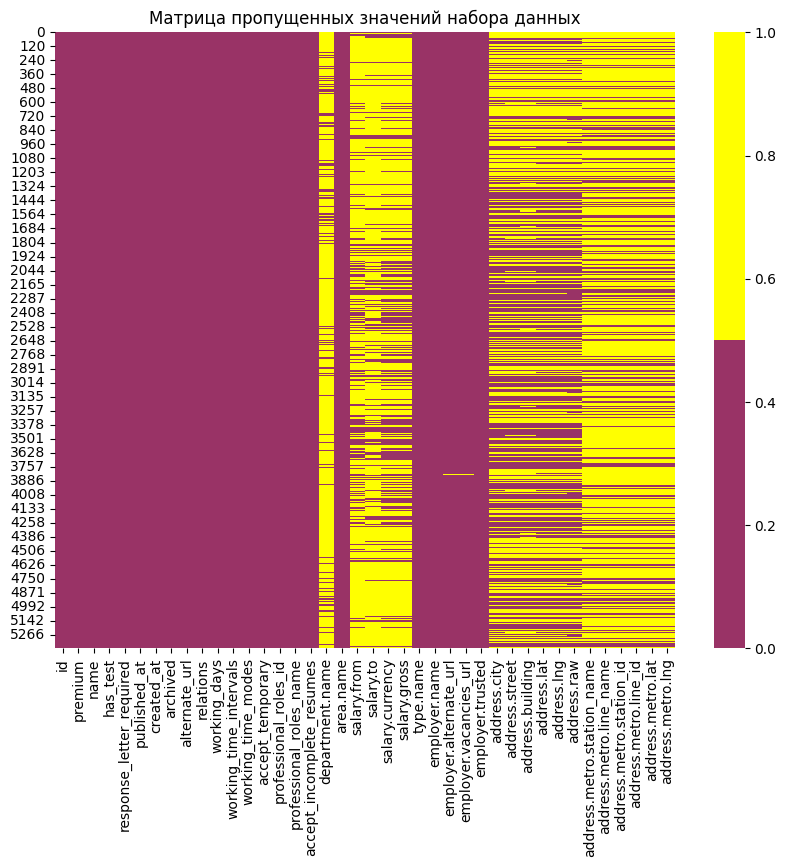

In [177]:
fig, ax = plt.subplots(figsize=(10, 8))
colours = ['#993366', '#FFFF00']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours), ax=ax)
# Decorations
plt.title('Матрица пропущенных значений набора данных', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [178]:
df.describe()


,salary.from,salary.to,address.lat,address.lng,address.metro.lat,address.metro.lng
count,1445.000000,996.000000,2686.000000,2686.000000,1569.000000,1569.000000
mean,84271.079585,121755.567269,54.971955,43.679933,56.379588,38.923768
std,56719.392566,85711.145715,6.229884,18.437601,1.539371,9.284012
min,70.000000,1300.000000,0.000000,-117.780920,53.200442,30.202470
25%,45000.000000,60000.000000,55.676066,37.532646,55.729741,37.526115
50%,70000.000000,99500.000000,55.755221,37.628190,55.765607,37.584990
75%,100000.000000,152100.000000,55.903893,43.950918,55.823342,37.657008
max,300000.000000,600000.000000,69.080757,135.189515,60.066990,82.952913


Кластеризация текстовых данных - это сложная задача машинного обучения, но можно использовать различные методы для ее решения. Вот несколько подходов:

1.Кластеризация на основе слов: вы можете использовать методы машинного обучения, такие как K-средних или DBSCAN, чтобы кластеризовать описания вакансий на основе слов в тексте. В этом случае вам нужно будет создать матрицу признаков, используя методы векторизации, такие как TF-IDF или Word2Vec, чтобы преобразовать текст в числовые значения. Затем можно использовать эти числа в качестве входных данных для алгоритма кластеризации.

2.Кластеризация на основе тем: другой подход - использовать тематическое моделирование для кластеризации описаний вакансий на основе тем, которые встречаются в тексте. Например, можно использовать методы LDA (Latent Dirichlet Allocation) или NMF (Non-Negative Matrix Factorization), чтобы найти темы, связанные с определенными профессиональными навыками или областями. Затем можно кластеризовать описания вакансий на основе этих тем.

3.Кластеризация на основе эмбеддингов: еще один подход - использовать предварительно обученные модели эмбеддингов (например, Word2Vec или GloVe), чтобы преобразовать текст в числовые векторы, представляющие значения слов. Затем можно использовать алгоритмы кластеризации, такие как DBSCAN или AgglomerativeClustering, чтобы кластеризовать описания вакансий на основе этих эмбеддингов.

Какой из этих подходов выбрать зависит от вашей задачи и доступных ресурсов. В любом случае, для успешной кластеризации необходимо иметь достаточно большой и разнообразный набор данных.

Воспользуемся Word2Vec:

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
# Создадим список списков слов для обучения модели Word2Vec. Для этого необходимо разбить каждое предложение 
# на список отдельных слов и добавить каждый список в основной список.

sentences = df["snippet.requirement"].apply(lambda x: x.split() if x else [])

In [ ]:
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)


In [ ]:
vectors = df['snippet.requirement'].apply(lambda x: model.wv[x.split()]).tolist()

In [ ]:
df['snippet.requirement'].isna().sum()

In [ ]:
df.shape

In [ ]:
df = df.dropna(subset=['snippet.requirement'])

In [ ]:
df.shape

In [ ]:
import numpy as np
vectors = np.array(df['snippet.requirement'].apply(lambda x: model.wv[x.split()]).tolist())


Для кластеризации векторов описаний вакансий можно использовать алгоритм кластеризации KMeans, который является одним из наиболее распространенных методов машинного обучения для кластеризации данных.

In [ ]:
from sklearn.cluster import KMeans

# Выберем количество кластеров
num_clusters = 10

# Инициализируем kmeans
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100)

# Обучаем kmeans на наших векторах
X = vectors
kmeans.fit(X)

# Получаем метки кластеров для наших векторов
cluster_labels = kmeans.labels_


In [ ]:
# Ошибка выше происходит из-за того, что массив содержит векторы разной длины
# Определим максимальную длину вектора среди всех векторов в списке:
max_len = max(len(v) for v in vectors)

# Добавим недостающие элементы в конец каждого вектора, заполнив их нулями:
for i, v in enumerate(vectors):
    vectors[i] = np.pad(v, (0, max_len - len(v)), 'constant')